# This file is huge.  Too hard to edit. Ignore this file

# Stacking House Prices - Walkthrough to Top 5%

### Arun Godwin Patel

## Content

1. **[Import packages](#import_packages)**
2. **[Load data](#load_data)**
3. **[Data preparation](#data_preparation)**
    - 3.1 - [Remove outliers](#remove_outliers)
    - 3.2 - [Treat missing values](#treat_missing_values)   
4. **[Exploratory Data Analysis](#exploratory_data_analysis)**
    - 4.1 - [Correlation matrix](#correlation_matrix)
    - 4.2 - [Feature engineering](#feature_engineering)
        - 4.2.1 - [Polynomials](#polynomials)
        - 4.2.2 - [Interior](#interior)
        - 4.2.3 - [Architectural & Structural](#architectural_&_structural)
        - 4.2.4 - [Exterior](#exterior)
        - 4.2.5 - [Location](#location)
        - 4.2.6 - [Land](#land)
        - 4.2.7 - [Access](#access)
        - 4.2.8 - [Utilities](#utilities)
        - 4.2.9 - [Miscellaneous](#miscellaneous)
    - 4.3 - [Target variable](#target_variable)
    - 4.4 - [Treating skewed features](#treating_skewed_features)
5. **[Modeling](#modeling)**
    - 5.1 - [Preparation of datasets](#preparation_of_datasets)
    - 5.2 - [Training](#training)
    - 5.3 - [Optimisation](#optimisation)
    - 5.4 - [Stacking](#stacking)
    - 5.5 - [Ensemble](#ensemble)
    - 5.6 - [Submission](#submission)
6. **[Conclusion](#conclusion)**   

<a id='import_packages'></a>
# 1. 
## Import packages

In [1]:
# This first set of packages include Pandas, for data manipulation, numpy for mathematical computation and matplotlib & seaborn, for visualisation.
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')

# Statistical packages used for transformations
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr
print('Statistical packages imported!')

# Algorithms used for modeling
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
print('Algorithm packages imported!')

# Pipeline and scaling preprocessing will be used for models that are sensitive
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and preprocessing packages imported!')

# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Model selection packages imported!')

# Set visualisation colours
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)
print('My colours are ready! :)')

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

Data Manipulation, Mathematical Computation and Visualisation packages imported!
Statistical packages imported!
Algorithm packages imported!
Pipeline and preprocessing packages imported!
Model selection packages imported!
My colours are ready! :)
Deprecation warning will be ignored!


<a id='load_data'></a>
# 2. 
## Load data

- The Pandas package helps us work with our datasets. We start by reading the training and test datasets into DataFrames.
- We want to save the 'Id' columns from both datasets for later use when preparing the submission data.
- But we can drop them from the training and test datasets as they are redundant.

In [3]:
train = pd.read_csv('../../../data/house_prices/train.csv')
test = pd.read_csv('../../../data/house_prices/test.csv')

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' column as it's redundant for modeling
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

<a id='data_preparation'></a>
# 3. 
## Data preparation

<a id='remove_outliers'></a>
### 3.1 - Remove outliers

***Outliers can be a Data Scientists nightmare.*** 

- By definition, an outlier is something that is outside of the expected response. How far you're willing to consider something to be an outlier, is down to the individual and the problem.
- From this definition, this outlier will therefore sit way outside of the distribution of data points. Hence, this will skew the distribution of the data and potential calculations.
- Let's see how this will affect predictions of the future.

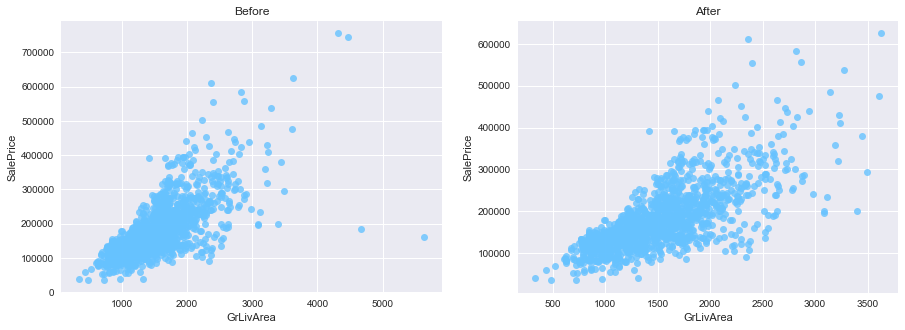

In [4]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['GrLivArea']>4000)].index)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("After")

In [5]:
# First of all, save the length of the training and test data for use later
ntrain = train.shape[0]
ntest = test.shape[0]

# Also save the target value, as we will remove this
y_train = train.SalePrice.values

# concatenate training and test data into all_data
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2915, 79)


### Fill NaN values

In [6]:
# Using data description, fill these missing values with "None"
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MSSubClass", "MasVnrType"):
    all_data[col] = all_data[col].fillna("None")
print("'None' - treated...")

# The area of the lot out front is likely to be similar to the houses in the local neighbourhood
# Therefore, let's use the median value of the houses in the neighbourhood to fill this feature
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
print("'LotFrontage' - treated...")

# Using data description, fill these missing values with 0 
for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)
print("'0' - treated...")


# Fill these features with their mode, the most commonly occuring value. This is okay since there are a low number of missing values for these features
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
print("'mode' - treated...")

all_data_na = all_data.isnull().sum()
print("Features with missing values: ", all_data_na.drop(all_data_na[all_data_na == 0].index))

'None' - treated...
'LotFrontage' - treated...
'0' - treated...
'mode' - treated...
Features with missing values:  Utilities    2
dtype: int64


Here we see that we have 1 remaining feature with missing values, Utilities.

- However, the test dataset has only 1 value for this column, which means that it holds no predictive power because it is a constant for all test observations.

Therefore, we can drop this column

In [7]:
all_data = all_data.drop(['Utilities'], axis=1)

<a id='exploratory_data_analysis'></a>
# 4. 
## Exploratory Data Analysis

In [10]:
# Quadratic
all_data["OverallQual-2"] = all_data["OverallQual"] ** 2
all_data["GrLivArea-2"] = all_data["GrLivArea"] ** 2
all_data["GarageCars-2"] = all_data["GarageCars"] ** 2
all_data["GarageArea-2"] = all_data["GarageArea"] ** 2
all_data["TotalBsmtSF-2"] = all_data["TotalBsmtSF"] ** 2
all_data["1stFlrSF-2"] = all_data["1stFlrSF"] ** 2
all_data["FullBath-2"] = all_data["FullBath"] ** 2
all_data["TotRmsAbvGrd-2"] = all_data["TotRmsAbvGrd"] ** 2
all_data["Fireplaces-2"] = all_data["Fireplaces"] ** 2
all_data["MasVnrArea-2"] = all_data["MasVnrArea"] ** 2
all_data["BsmtFinSF1-2"] = all_data["BsmtFinSF1"] ** 2
all_data["LotFrontage-2"] = all_data["LotFrontage"] ** 2
all_data["WoodDeckSF-2"] = all_data["WoodDeckSF"] ** 2
all_data["OpenPorchSF-2"] = all_data["OpenPorchSF"] ** 2
all_data["2ndFlrSF-2"] = all_data["2ndFlrSF"] ** 2
print("Quadratics done!...")

# Cubic
all_data["OverallQual-3"] = all_data["OverallQual"] ** 3
all_data["GrLivArea-3"] = all_data["GrLivArea"] ** 3
all_data["GarageCars-3"] = all_data["GarageCars"] ** 3
all_data["GarageArea-3"] = all_data["GarageArea"] ** 3
all_data["TotalBsmtSF-3"] = all_data["TotalBsmtSF"] ** 3
all_data["1stFlrSF-3"] = all_data["1stFlrSF"] ** 3
all_data["FullBath-3"] = all_data["FullBath"] ** 3
all_data["TotRmsAbvGrd-3"] = all_data["TotRmsAbvGrd"] ** 3
all_data["Fireplaces-3"] = all_data["Fireplaces"] ** 3
all_data["MasVnrArea-3"] = all_data["MasVnrArea"] ** 3
all_data["BsmtFinSF1-3"] = all_data["BsmtFinSF1"] ** 3
all_data["LotFrontage-3"] = all_data["LotFrontage"] ** 3
all_data["WoodDeckSF-3"] = all_data["WoodDeckSF"] ** 3
all_data["OpenPorchSF-3"] = all_data["OpenPorchSF"] ** 3
all_data["2ndFlrSF-3"] = all_data["2ndFlrSF"] ** 3
print("Cubics done!...")

# Square Root
all_data["OverallQual-Sq"] = np.sqrt(all_data["OverallQual"])
all_data["GrLivArea-Sq"] = np.sqrt(all_data["GrLivArea"])
all_data["GarageCars-Sq"] = np.sqrt(all_data["GarageCars"])
all_data["GarageArea-Sq"] = np.sqrt(all_data["GarageArea"])
all_data["TotalBsmtSF-Sq"] = np.sqrt(all_data["TotalBsmtSF"])
all_data["1stFlrSF-Sq"] = np.sqrt(all_data["1stFlrSF"])
all_data["FullBath-Sq"] = np.sqrt(all_data["FullBath"])
all_data["TotRmsAbvGrd-Sq"] = np.sqrt(all_data["TotRmsAbvGrd"])
all_data["Fireplaces-Sq"] = np.sqrt(all_data["Fireplaces"])
all_data["MasVnrArea-Sq"] = np.sqrt(all_data["MasVnrArea"])
all_data["BsmtFinSF1-Sq"] = np.sqrt(all_data["BsmtFinSF1"])
all_data["LotFrontage-Sq"] = np.sqrt(all_data["LotFrontage"])
all_data["WoodDeckSF-Sq"] = np.sqrt(all_data["WoodDeckSF"])
all_data["OpenPorchSF-Sq"] = np.sqrt(all_data["OpenPorchSF"])
all_data["2ndFlrSF-Sq"] = np.sqrt(all_data["2ndFlrSF"])
print("Roots done!...")

Quadratics done!...
Cubics done!...
Roots done!...


### BsmtQual

In [12]:
for col in ("BsmtQual", "HeatingQC", "BsmtCond", "FireplaceQu", "BsmtExposure", "KitchenQual", 
            "ExterQual"):
    all_data[col] = all_data[col].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

for col in ("BsmtFinType1", "BsmtFinType2", "RoofStyle", "RoofMatl", "Fence",
            "LotShape", "LandContour", "PavedDrive", "SaleCondition", "YrSold",
            "MoSold", "Alley", "MSZoning", "Neighborhood", "MasVnrType",
            "ExterCond", "GarageType", "GarageFinish"):
    all_data = pd.get_dummies(all_data, columns=[col], prefix=col)
    
for col in ("BsmtFinSF2", "LowQualFinSF"):
    all_data['{}_Flag'.format(col)] = all_data[col].map(lambda x:0 if x==0 else 1)
    all_data.drop(col, axis=1, inplace=True)
    
for col in ("MSSubClass", "BldgType"):
    all_data[col] = all_data[col].astype(str)
    all_data = pd.get_dummies(all_data, columns = [col], prefix=col)
    
for col in ("MasVnrArea", "PoolQC", 'MiscFeature', 'MiscVal'):
    all_data.drop(col, axis=1, inplace=True)
    

all_data['BsmtFinSF1_Band'] = pd.cut(all_data['BsmtFinSF1'], 4)
all_data.loc[all_data['BsmtFinSF1']<=1002.5, 'BsmtFinSF1'] = 1
all_data.loc[(all_data['BsmtFinSF1']>1002.5) & (all_data['BsmtFinSF1']<=2005), 'BsmtFinSF1'] = 2
all_data.loc[(all_data['BsmtFinSF1']>2005) & (all_data['BsmtFinSF1']<=3007.5), 'BsmtFinSF1'] = 3
all_data.loc[all_data['BsmtFinSF1']>3007.5, 'BsmtFinSF1'] = 4
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].astype(int)
all_data.drop('BsmtFinSF1_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["BsmtFinSF1"], prefix="BsmtFinSF1")


all_data['TotalBathrooms'] = all_data['BsmtHalfBath'] + all_data['BsmtFullBath'] + all_data['HalfBath'] + all_data['FullBath']
columns = ['BsmtHalfBath', 'BsmtFullBath', 'HalfBath', 'FullBath']
all_data.drop(columns, axis=1, inplace=True)


all_data['HouseStyle'] = all_data['HouseStyle'].map({"2Story":"2Story", "1Story":"1Story", "1.5Fin":"1.5Story", "1.5Unf":"1.5Story", 
                                                     "SFoyer":"SFoyer", "SLvl":"SLvl", "2.5Unf":"2.5Story", "2.5Fin":"2.5Story"})
all_data = pd.get_dummies(all_data, columns = ["HouseStyle"], prefix="HouseStyle")

train['Remod_Diff'] = train['YearRemodAdd'] - train['YearBuilt']

all_data['Remod_Diff'] = all_data['YearRemodAdd'] - all_data['YearBuilt']
all_data.drop('YearRemodAdd', axis=1, inplace=True)

all_data['YearBuilt_Band'] = pd.cut(all_data['YearBuilt'], 7)
all_data.loc[all_data['YearBuilt']<=1892, 'YearBuilt'] = 1
all_data.loc[(all_data['YearBuilt']>1892) & (all_data['YearBuilt']<=1911), 'YearBuilt'] = 2
all_data.loc[(all_data['YearBuilt']>1911) & (all_data['YearBuilt']<=1931), 'YearBuilt'] = 3
all_data.loc[(all_data['YearBuilt']>1931) & (all_data['YearBuilt']<=1951), 'YearBuilt'] = 4
all_data.loc[(all_data['YearBuilt']>1951) & (all_data['YearBuilt']<=1971), 'YearBuilt'] = 5
all_data.loc[(all_data['YearBuilt']>1971) & (all_data['YearBuilt']<=1990), 'YearBuilt'] = 6
all_data.loc[all_data['YearBuilt']>1990, 'YearBuilt'] = 7
all_data['YearBuilt'] = all_data['YearBuilt'].astype(int)
all_data.drop('YearBuilt_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["YearBuilt"], prefix="YearBuilt")

all_data = pd.get_dummies(all_data, columns = ["Foundation"], prefix="Foundation")

all_data['Functional'] = all_data['Functional'].map({"Sev":1, "Maj2":2, "Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7})

array([3, 2, 4, 0, 1])

In [29]:
def Exter2(col):
    return 1 if col['Exterior2nd'] == col['Exterior1st'] else 0:
    
all_data['ExteriorMatch_Flag'] = all_data.apply(Exter2, axis=1)
all_data.drop('Exterior2nd', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["Exterior1st"], prefix="Exterior1st")

In [9]:
all_data['GarageYrBlt_Band'] = pd.qcut(all_data['GarageYrBlt'], 3)
all_data.loc[all_data['GarageYrBlt']<=1964, 'GarageYrBlt'] = 1
all_data.loc[(all_data['GarageYrBlt']>1964) & (all_data['GarageYrBlt']<=1996), 'GarageYrBlt'] = 2
all_data.loc[all_data['GarageYrBlt']>1996, 'GarageYrBlt'] = 3
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(int)
all_data.drop('GarageYrBlt_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["GarageYrBlt"], prefix="GarageYrBlt")

all_data['GarageArea_Band'] = pd.cut(all_data['GarageArea'], 3)
all_data.loc[all_data['GarageArea']<=496, 'GarageArea'] = 1
all_data.loc[(all_data['GarageArea']>496) & (all_data['GarageArea']<=992), 'GarageArea'] = 2
all_data.loc[all_data['GarageArea']>992, 'GarageArea'] = 3
all_data['GarageArea'] = all_data['GarageArea'].astype(int)
all_data.drop('GarageArea_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["GarageArea"], prefix="GarageArea")

all_data['GarageQual'] = all_data['GarageQual'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data = pd.get_dummies(all_data, columns = ["GarageQual"], prefix="GarageQual")

all_data['GarageCond'] = all_data['GarageCond'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data = pd.get_dummies(all_data, columns = ["GarageCond"], prefix="GarageCond")

In [104]:
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch'] 
train['TotalPorchSF'] = train['OpenPorchSF'] + train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

In [120]:
all_data['Condition1'] = all_data['Condition1'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
all_data['Condition2'] = all_data['Condition2'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})

In [14]:
# def ConditionMatch(col):
#     return 0 if col['Condition1'] == col['Condition2'] else 1
    
# all_data['Diff2ndCondition_Flag'] = all_data.apply(ConditionMatch, axis=1)
# all_data.drop('Condition2', axis=1, inplace=True)

# all_data = pd.get_dummies(all_data, columns = ["Condition1"], prefix="Condition1")

In [124]:
all_data['LotArea_Band'] = pd.qcut(all_data['LotArea'], 8)

[(7474.0, 8520.0], (9450.0, 10355.25], (10355.25, 11554.5], (13613.0, 215245.0], (5684.75, 7474.0], (11554.5, 13613.0], (1299.999, 5684.75], (8520.0, 9450.0]]
Categories (8, interval[float64]): [(1299.999, 5684.75] < (5684.75, 7474.0] < (7474.0, 8520.0] < (8520.0, 9450.0] < (9450.0, 10355.25] < (10355.25, 11554.5] < (11554.5, 13613.0] < (13613.0, 215245.0]]

In [18]:
all_data['LotConfig'] = all_data['LotConfig'].map({"Inside":"Inside", "FR2":"FR", "Corner":"Corner", "CulDSac":"CulDSac", "FR3":"FR"})

all_data = pd.get_dummies(all_data, columns = ["LotConfig"], prefix="LotConfig")

In [133]:
all_data['LandSlope'] = all_data['LandSlope'].map({"Gtl":1, "Mod":2, "Sev":2})

In [136]:
all_data.drop('Street', axis=1, inplace=True)

In [21]:
# all_data['GasA_Flag'] = all_data['Heating'].map(lambda x: 1 if x == "GasA" else 0)
# all_data.drop('Heating', axis=1, inplace=True)

In [22]:
# all_data['HeatingQC'] = all_data['HeatingQC'].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

In [23]:
# all_data['CentralAir'] = all_data['CentralAir'].map({"Y":1, "N":0})

In [24]:
all_data['Electrical'] = all_data['Electrical'].map({"SBrkr":"SBrkr", "FuseF":"Fuse", "FuseA":"Fuse", "FuseP":"Fuse", "Mix":"Mix"})
all_data = pd.get_dummies(all_data, columns = ["Electrical"], prefix="Electrical")

In [27]:
# all_data['SaleType'] = all_data['SaleType'].map({"WD":"WD", "New":"New", "COD":"COD", "CWD":"CWD", "ConLD":"Oth", "ConLI":"Oth", 
#                                                  "ConLw":"Oth", "Con":"Oth", "Oth":"Oth"})

# all_data = pd.get_dummies(all_data, columns = ["SaleType"], prefix="SaleType")

In [ ]:
def Slope(col):
    return 1 if col['LandSlope'] == 1 else 0
    
all_data['GentleSlope_Flag'] = all_data.apply(Slope, axis=1)
all_data.drop('LandSlope', axis=1, inplace=True)

def PoolFlag(col):
    return 1 if col['PoolArea'] == 0 else 0
    
all_data['HasPool_Flag'] = all_data.apply(PoolFlag, axis=1)
all_data.drop('PoolArea', axis=1, inplace=True)

def PorchFlag(col):
    return 1 if col['TotalPorchSF'] == 0 else 0

all_data['NoPorch_Flag'] = all_data.apply(PorchFlag, axis=1)
all_data['TotalPorchSF_Band'] = pd.cut(all_data['TotalPorchSF'], 4)
all_data.loc[all_data['TotalPorchSF']<=431, 'TotalPorchSF'] = 1
all_data.loc[(all_data['TotalPorchSF']>431) & (all_data['TotalPorchSF']<=862), 'TotalPorchSF'] = 2
all_data.loc[(all_data['TotalPorchSF']>862) & (all_data['TotalPorchSF']<=1293), 'TotalPorchSF'] = 3
all_data.loc[all_data['TotalPorchSF']>1293, 'TotalPorchSF'] = 4
all_data['TotalPorchSF'] = all_data['TotalPorchSF'].astype(int)
all_data.drop('TotalPorchSF_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["TotalPorchSF"], prefix="TotalPorchSF")

def WoodDeckFlag(col):
    return 1 if col['WoodDeckSF'] == 0 else 0
    
all_data['NoWoodDeck_Flag'] = all_data.apply(WoodDeckFlag, axis=1)
all_data['WoodDeckSF_Band'] = pd.cut(all_data['WoodDeckSF'], 4)
all_data.loc[all_data['WoodDeckSF']<=356, 'WoodDeckSF'] = 1
all_data.loc[(all_data['WoodDeckSF']>356) & (all_data['WoodDeckSF']<=712), 'WoodDeckSF'] = 2
all_data.loc[(all_data['WoodDeckSF']>712) & (all_data['WoodDeckSF']<=1068), 'WoodDeckSF'] = 3
all_data.loc[all_data['WoodDeckSF']>1068, 'WoodDeckSF'] = 4
all_data['WoodDeckSF'] = all_data['WoodDeckSF'].astype(int)
all_data.drop('WoodDeckSF_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["WoodDeckSF"], prefix="WoodDeckSF")

all_data['BsmtUnfSF_Band'] = pd.cut(all_data['BsmtUnfSF'], 3)
all_data.loc[all_data['BsmtUnfSF']<=778.667, 'BsmtUnfSF'] = 1
all_data.loc[(all_data['BsmtUnfSF']>778.667) & (all_data['BsmtUnfSF']<=1557.333), 'BsmtUnfSF'] = 2
all_data.loc[all_data['BsmtUnfSF']>1557.333, 'BsmtUnfSF'] = 3
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].astype(int)
all_data.drop('BsmtUnfSF_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["BsmtUnfSF"], prefix="BsmtUnfSF")

all_data['GrLivArea_Band'] = pd.cut(all_data['GrLivArea'], 6)
all_data.loc[all_data['GrLivArea']<=1127.5, 'GrLivArea'] = 1
all_data.loc[(all_data['GrLivArea']>1127.5) & (all_data['GrLivArea']<=1921), 'GrLivArea'] = 2
all_data.loc[(all_data['GrLivArea']>1921) & (all_data['GrLivArea']<=2714.5), 'GrLivArea'] = 3
all_data.loc[(all_data['GrLivArea']>2714.5) & (all_data['GrLivArea']<=3508), 'GrLivArea'] = 4
all_data.loc[(all_data['GrLivArea']>3508) & (all_data['GrLivArea']<=4301.5), 'GrLivArea'] = 5
all_data.loc[all_data['GrLivArea']>4301.5, 'GrLivArea'] = 6
all_data['GrLivArea'] = all_data['GrLivArea'].astype(int)
all_data.drop('GrLivArea_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["GrLivArea"], prefix="GrLivArea")

all_data['TotalBsmtSF_Band'] = pd.cut(all_data['TotalBsmtSF'], 10)
all_data.loc[all_data['TotalBsmtSF']<=509.5, 'TotalBsmtSF'] = 1
all_data.loc[(all_data['TotalBsmtSF']>509.5) & (all_data['TotalBsmtSF']<=1019), 'TotalBsmtSF'] = 2
all_data.loc[(all_data['TotalBsmtSF']>1019) & (all_data['TotalBsmtSF']<=1528.5), 'TotalBsmtSF'] = 3
all_data.loc[(all_data['TotalBsmtSF']>1528.5) & (all_data['TotalBsmtSF']<=2038), 'TotalBsmtSF'] = 4
all_data.loc[(all_data['TotalBsmtSF']>2038) & (all_data['TotalBsmtSF']<=2547.5), 'TotalBsmtSF'] = 5
all_data.loc[(all_data['TotalBsmtSF']>2547.5) & (all_data['TotalBsmtSF']<=3057), 'TotalBsmtSF'] = 6
all_data.loc[(all_data['TotalBsmtSF']>3057) & (all_data['TotalBsmtSF']<=3566.5), 'TotalBsmtSF'] = 7
all_data.loc[all_data['TotalBsmtSF']>3566.5, 'TotalBsmtSF'] = 8
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].astype(int)
all_data.drop('TotalBsmtSF_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["TotalBsmtSF"], prefix="TotalBsmtSF")

all_data['1stFlrSF_Band'] = pd.cut(all_data['1stFlrSF'], 6)
all_data.loc[all_data['1stFlrSF']<=1127.5, '1stFlrSF'] = 1
all_data.loc[(all_data['1stFlrSF']>1127.5) & (all_data['1stFlrSF']<=1921), '1stFlrSF'] = 2
all_data.loc[(all_data['1stFlrSF']>1921) & (all_data['1stFlrSF']<=2714.5), '1stFlrSF'] = 3
all_data.loc[(all_data['1stFlrSF']>2714.5) & (all_data['1stFlrSF']<=3508), '1stFlrSF'] = 4
all_data.loc[(all_data['1stFlrSF']>3508) & (all_data['1stFlrSF']<=4301.5), '1stFlrSF'] = 5
all_data.loc[all_data['1stFlrSF']>4301.5, '1stFlrSF'] = 6
all_data['1stFlrSF'] = all_data['1stFlrSF'].astype(int)
all_data.drop('1stFlrSF_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["1stFlrSF"], prefix="1stFlrSF")

all_data['2ndFlrSF_Band'] = pd.cut(all_data['2ndFlrSF'], 6)
all_data.loc[all_data['2ndFlrSF']<=310.333, '2ndFlrSF'] = 1
all_data.loc[(all_data['2ndFlrSF']>310.333) & (all_data['2ndFlrSF']<=620.667), '2ndFlrSF'] = 2
all_data.loc[(all_data['2ndFlrSF']>620.667) & (all_data['2ndFlrSF']<=931), '2ndFlrSF'] = 3
all_data.loc[(all_data['2ndFlrSF']>931) & (all_data['2ndFlrSF']<=1241.333), '2ndFlrSF'] = 4
all_data.loc[(all_data['2ndFlrSF']>1241.333) & (all_data['2ndFlrSF']<=1551.667), '2ndFlrSF'] = 5
all_data.loc[all_data['2ndFlrSF']>1551.667, '2ndFlrSF'] = 6
all_data['2ndFlrSF'] = all_data['2ndFlrSF'].astype(int)
all_data.drop('2ndFlrSF_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["2ndFlrSF"], prefix="2ndFlrSF")

all_data.loc[all_data['LotArea']<=5684.75, 'LotArea'] = 1
all_data.loc[(all_data['LotArea']>5684.75) & (all_data['LotArea']<=7474), 'LotArea'] = 2
all_data.loc[(all_data['LotArea']>7474) & (all_data['LotArea']<=8520), 'LotArea'] = 3
all_data.loc[(all_data['LotArea']>8520) & (all_data['LotArea']<=9450), 'LotArea'] = 4
all_data.loc[(all_data['LotArea']>9450) & (all_data['LotArea']<=10355.25), 'LotArea'] = 5
all_data.loc[(all_data['LotArea']>10355.25) & (all_data['LotArea']<=11554.25), 'LotArea'] = 6
all_data.loc[(all_data['LotArea']>11554.25) & (all_data['LotArea']<=13613), 'LotArea'] = 7
all_data.loc[all_data['LotArea']>13613, 'LotArea'] = 8
all_data['LotArea'] = all_data['LotArea'].astype(int)
all_data.drop('LotArea_Band', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns = ["LotArea"], prefix="LotArea")

***

<a id='target_variable'></a>
### 4.3 - Target Variable

- Unlike classification, **in regression we are predicting a continuous number**. Hence, the prediction could be any number along the real number line.
- Therefore, it is always useful to check the distribution of the target variable, and indeed all numeric variables, when building a regression model. Machine Learning algorithms work well with features that are **normally distributed**, a distribution that is symmetric and has a characteristic bell shape. If features are not normally distributed, you can transform them using clever statistical methods.
- First, let's check the target variable.

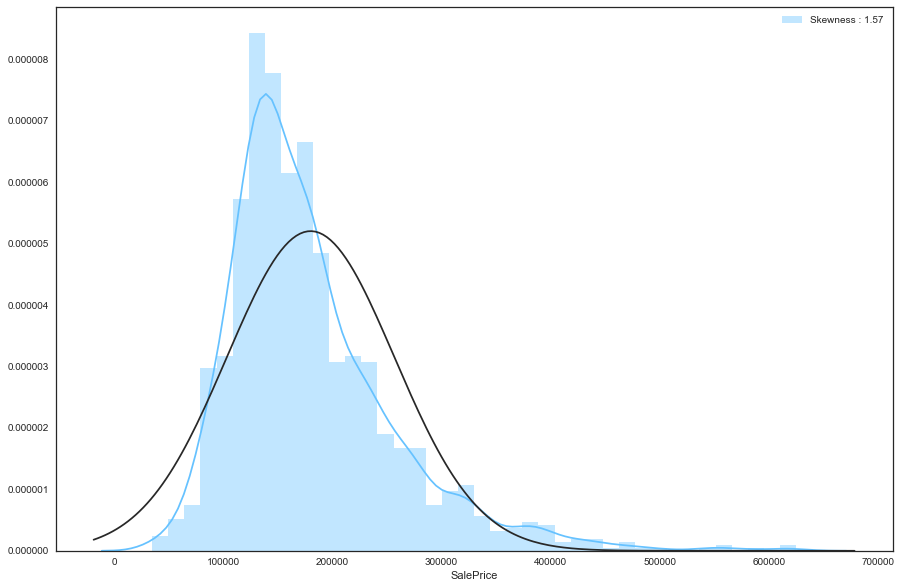

In [159]:
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

The distribution of the target variable is **positively skewed**, meaning that the mode is always less than the mean and median. 

- In order to transform this variable into a distribution that looks closer to the black line shown above, we can use the **numpy function log1p** which applies log(1+x) to all elements within the feature.

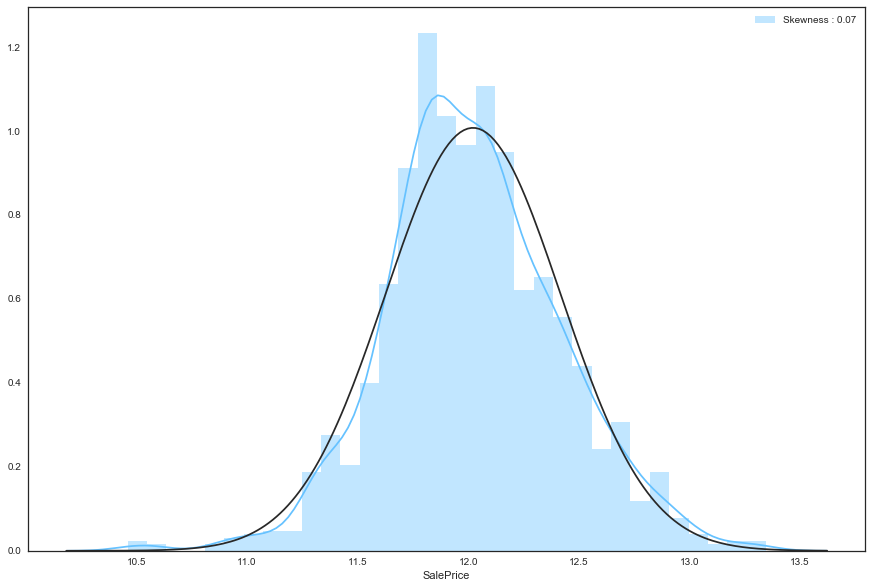

In [160]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train["SalePrice"]

#Check the new distribution 
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

We can see from the skewness and the plot that it follows much more closely to the normal distribution now. **This will help the algorithms work most reliably because we are now predicting a distribution that is well-known, i.e. the normal distribution**. If the distribution of your data approximates that of a theoretical distribution, we can perform calculations on the data that are based on assumptions of that well-known distribution. 

- ***Note:*** Now that we have transformed the target variable, this means that the prediction we produce will also be in the form of this transformation. Unless, we can revert this transformation...

<a id='treating_skewed_features'></a>
### 4.4 - Treating skewed features

As touched on earlier, skewed numeric variables are not desirable when using Machine Learning algorithms. The reason why we want to do this is move the models focus away from any extreme values, to create a generalised solution. We can tame these extreme values by transforming skewed features.

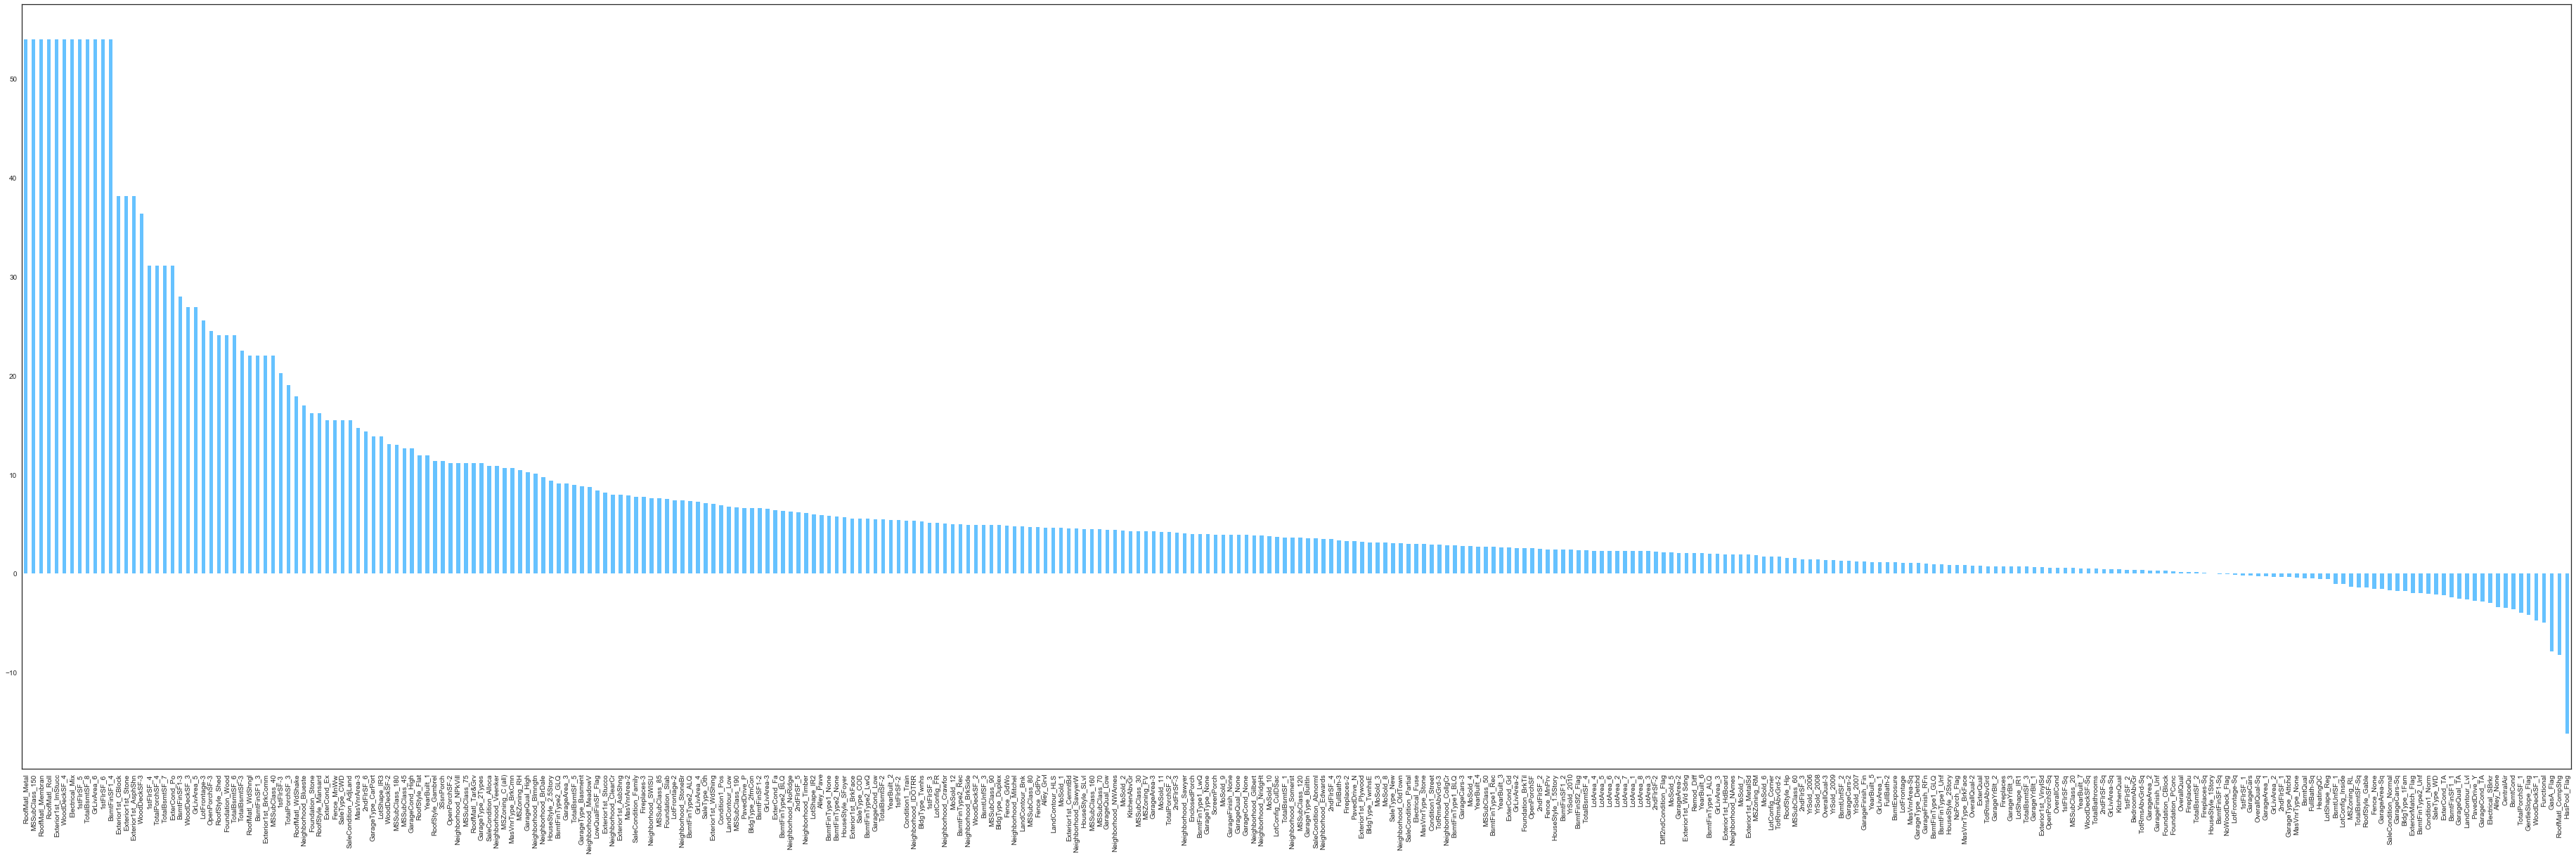

In [161]:
# First lets single out the numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check how skewed they are
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

plt.subplots(figsize =(65, 20))
skewed_feats.plot(kind='bar');

Clearly, we have a variety of positive and negative skewing features. Now I will transform the features with skew > 0.5 to follow more closely the normal distribution.

- **Note**: I am using the Box-Cox transformation to transform non-normal variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn't normal, applying a Box-Cox means that you are able to run a broader number of tests.

In [162]:
skewness = skewed_feats[abs(skewed_feats) > 0.5]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

302 skewed numerical features have been Box-Cox transformed


<a id='modeling'></a>
# 5. 
## Modeling

<a id='preparation_of_data'></a>
### 5.1 - Preparation of data

- Now that our dataset is ready for modeling, we must prepare it from training, testing and prediction. One of the vital steps here is to reduce the number of features. I will do this using XGBoost's inbuilt feature importance functionality.

In [163]:
# First, re-create the training and test datasets
train = all_data[:ntrain]
test = all_data[ntrain:]

print(train.shape)
print(test.shape)

(1456, 330)
(1459, 330)


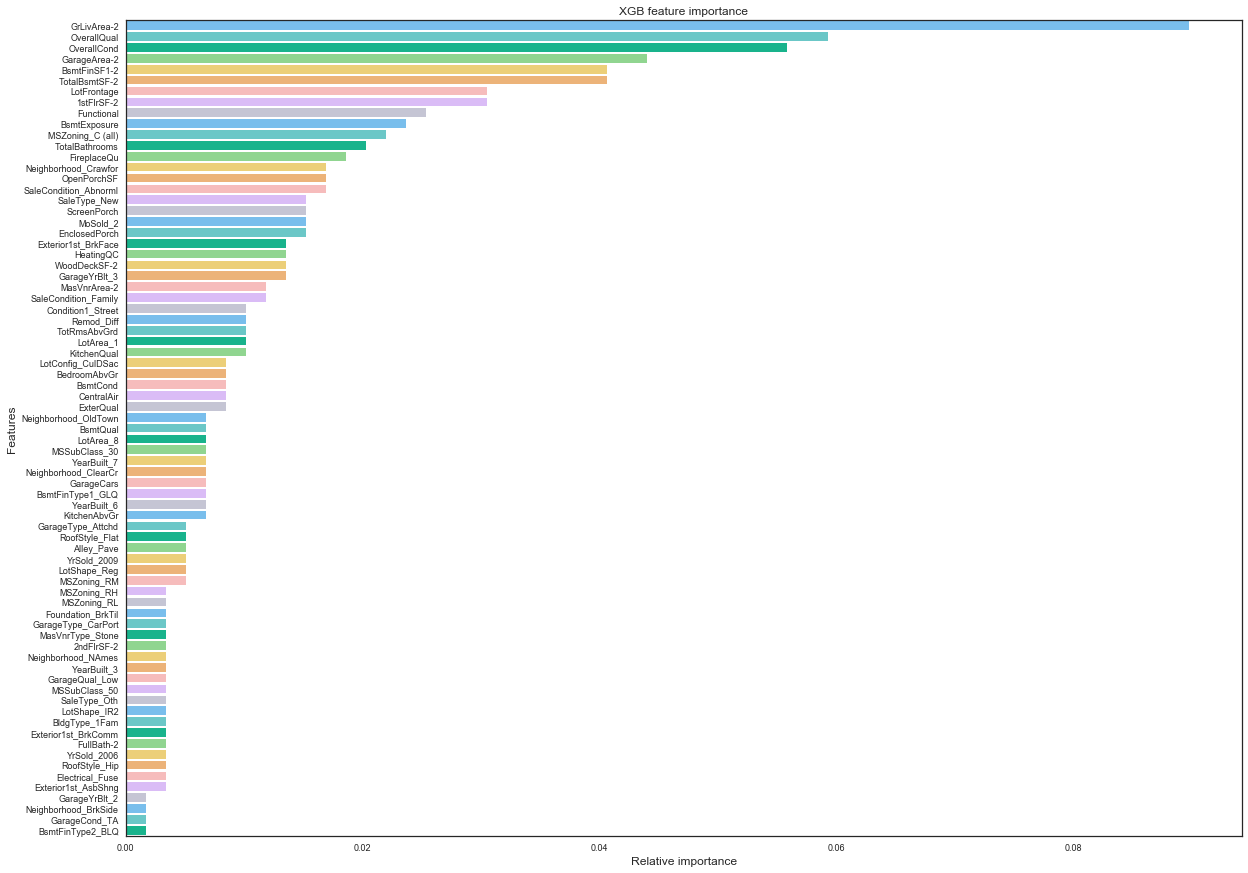

In [164]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(train, y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(model.feature_importances_)[::-1]
indices = indices[:75]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=train.columns[indices], x = model.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB feature importance");

In [165]:
xgb_train = train.copy()
xgb_test = test.copy()

import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(xgb_train, y_train)

# Allow the feature importances attribute to select the most important features
xgb_feat_red = SelectFromModel(model, prefit = True)

# Reduce estimation, validation and test datasets
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_test = xgb_feat_red.transform(xgb_test)


print("Results of 'feature_importances_':")
print('X_train: ', xgb_train.shape, '\nX_test: ', xgb_test.shape)

Results of 'feature_importances_':
X_train:  (1456, 71) 
X_test:  (1459, 71)


In [166]:
# Next we want to sample our training data to test for performance of robustness ans accuracy, before applying to the test data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(xgb_train, y_train, test_size=0.3, random_state=42)

print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (1019, 71) 
X_test:  (437, 71) 
Y_train:  (1019,) 
Y_test:  (437,)


<a id='training'></a>
### 5.2 - Training

We are finally ready to train our models. For this analysis I am using 8 different algorithms:
- **Kernel Ridge Regression**
- **Elastic Net**
- **Lasso**
- **Gradient Boosting**
- **Bayesian Ridge**
- **Lasso Lars IC**
- **Random Forest Regressor**
- **XGBoost**

The method of measuring accuracy was chosen to be **Root Mean Squared Error**, as described within the competition.

In [183]:
import xgboost as xgb
#Machine Learning Algorithm (MLA) Selection and Initialization
models = [KernelRidge(alpha=0.1, coef0=100, degree=1, gamma=None, kernel='polynomial'), 
          
          ElasticNet(alpha=0.001, copy_X=True, l1_ratio=0.6, fit_intercept=True, normalize=False, 
                         precompute=False, max_iter=300, tol=0.001, selection='random', random_state=None),
          
          Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, normalize=False, precompute=False, 
                    max_iter=300, tol=0.01, selection='random', random_state=None),
                
          GradientBoostingRegressor(loss='huber', learning_rate=0.1, n_estimators=300, max_depth=3, 
                                        min_samples_split=0.0025, min_samples_leaf=5),
                
          BayesianRidge(n_iter=200, tol=0.00001, alpha_1=0.00000001, alpha_2=0.000005, lambda_1=0.000005, 
                 lambda_2=0.00000001, copy_X=True),
                
          LassoLarsIC(criterion='aic', normalize=True, max_iter=100, copy_X=True, precompute='auto', eps=0.000001),
                
          RandomForestRegressor(n_estimators=50, max_features='auto', max_depth=None, min_samples_split=5, min_samples_leaf=2),
                
          xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=300, booster='gbtree', gamma=0, reg_alpha=0.1,
                  reg_lambda=0.7, max_delta_step=0, min_child_weight=1, colsample_bytree=0.5, colsample_bylevel=0.2,
                  scale_pos_weight=1)]
          
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']

# First I will use ShuffleSplit as a way of randomising the cross validation samples.
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#create table to compare MLA metrics
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

#index through models and save performance to table
row_index = 0
for alg in models:

    #set name and parameters
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, Y_train)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    training_results = np.sqrt((-cross_val_score(alg, X_train, Y_train, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt(((Y_test-alg.predict(X_test))**2).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_results)*100
    before_model_compare.loc[row_index, 'Test Accuracy'] = (test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
8 XGBRegressor trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 0.1, 'coef0': 100, 'degree': 1, 'gam...",11.212,11.911
1,ElasticNet,"{'alpha': 0.001, 'copy_X': True, 'fit_intercep...",11.219,11.913
2,Lasso,"{'alpha': 0.0005, 'copy_X': True, 'fit_interce...",11.209,11.806
3,GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",12.096,12.149
4,BayesianRidge,"{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'compute_...",11.229,11.759
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 1e...",12.552,12.511
6,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",13.820,13.974
7,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",11.953,12.172


- We can see that each of the models performs with varying ability, with **Bayesian Ridge** having the best accuracy score on the training dataset and accuracy on the validation dataset.

<a id='stacking'></a>
### 5.4 - Stacking

Now that we have a set of highly tuned algorithms, a rather famous and successful technique to further improve the accuracy of these models, is to use **Stacking**.

- Before I start with the stacking, I need to decide which algorithms to use as my base estimators, and which to use as the meta-model.

- Since **Lasso** performed the best after optimisation, I chose this to be the **meta-model**. All other models will be used as base estimators.

- So now, I will cycle through each optimised estimator, train them on the training dataset, apply to them the validation and test datasets, then finally outputting the predictions for validation and test into two new datasets: **stacked_validation_train** and **stacked_test_train**.

In [184]:
stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index=0

for alg in models:
    
    alg.fit(X_train, Y_train)

    stacked_validation_train.insert(loc = row_index, column = names[0], value = alg.predict(X_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking validation dataset...')
    
    stacked_test_train.insert(loc = row_index, column = names[0], value = alg.predict(xgb_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking test dataset...')
    print("-"*50)
    names.pop(0)
    
    row_index+=1
    
print('Done')

1 KernelRidge predictions added to stacking validation dataset...
1 KernelRidge predictions added to stacking test dataset...
--------------------------------------------------
2 ElasticNet predictions added to stacking validation dataset...
2 ElasticNet predictions added to stacking test dataset...
--------------------------------------------------
3 Lasso predictions added to stacking validation dataset...
3 Lasso predictions added to stacking test dataset...
--------------------------------------------------
4 GradientBoostingRegressor predictions added to stacking validation dataset...
4 GradientBoostingRegressor predictions added to stacking test dataset...
--------------------------------------------------
5 BayesianRidge predictions added to stacking validation dataset...
5 BayesianRidge predictions added to stacking test dataset...
--------------------------------------------------
6 LassoLarsIC predictions added to stacking validation dataset...
6 LassoLarsIC predictions added

- Let's take a quick look at what these new datasets look like:

In [185]:
stacked_validation_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,12.095862,12.065847,12.076556,12.118402,12.107290,12.104415,12.139630,12.050997
1,11.934928,11.959988,11.957380,12.018334,11.924513,12.006002,12.077802,12.010094
2,11.785004,11.788683,11.792838,11.877250,11.786723,11.781243,11.864658,11.822491
3,11.786236,11.761529,11.764500,11.843397,11.787922,11.839399,11.705002,11.713875
4,11.294088,11.261165,11.268246,11.193234,11.293757,11.302433,11.365834,11.388784


- The new training dataset is 438 rows of predictions from the 8 algorithms we decided to use.

In [186]:
stacked_test_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,11.666129,11.688219,11.684127,11.737250,11.663755,11.644445,11.725988,11.695753
1,12.048428,12.057638,12.054457,11.955923,12.046563,11.998478,11.988896,11.971147
2,12.114796,12.111180,12.115407,12.137456,12.116697,12.057223,12.087362,12.099539
3,12.207342,12.209319,12.211576,12.134427,12.209729,12.129703,12.109560,12.230280
4,12.127530,12.141045,12.134993,12.129930,12.114497,12.172302,12.202191,12.110150


- The new test dataset is 1459 rows of predictions from the 8 algorithms we decided to use.
- I will use these two datasets to train and produce predictions for the meta-model, Lasso.

In [187]:
# First drop the Lasso results from the table, as we will be using Lasso as the meta-model
drop = ['Lasso']
stacked_validation_train.drop(drop, axis=1, inplace=True)
stacked_test_train.drop(drop, axis=1, inplace=True)

# Now fit the meta model and generate predictions
meta_model = make_pipeline(RobustScaler(), Lasso(alpha=0.00001, copy_X = True, fit_intercept = True,
                                              normalize = False, precompute = False, max_iter = 10000,
                                              tol = 0.0001, selection = 'random', random_state = None))
meta_model.fit(stacked_validation_train, Y_test)

meta_model_pred = np.expm1(meta_model.predict(stacked_test_train))
print("Meta-model trained and applied!...")

Meta-model trained and applied!...


***

<a id='ensemble'></a>
### 5.5 - Ensemble

- However, another famous and successful technique for Machine Learning are **Ensemble methods**.
    - These are effective when using many different models of varying degrees of accuracy. 
    - They work on the idea that many weak learners, can produce a strong learner.
- Therefore, using the meta-model that I will create, I will also combine this with the results of the individual optimised models to create an ensemble.
- In order to create this ensemble, I must collect the final predictions of each of the optimised models. I will do this now.

In [188]:
models = [KernelRidge(alpha=0.1, coef0=100, degree=1, gamma=None, kernel='polynomial'), 
          
          ElasticNet(alpha=0.001, copy_X=True, l1_ratio=0.6, fit_intercept=True, normalize=False, 
                         precompute=False, max_iter=300, tol=0.001, selection='random', random_state=None),
          
          Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, normalize=False, precompute=False, 
                    max_iter=300, tol=0.01, selection='random', random_state=None),
                
          GradientBoostingRegressor(loss='huber', learning_rate=0.1, n_estimators=300, max_depth=3, 
                                        min_samples_split=0.0025, min_samples_leaf=5),
                
          BayesianRidge(n_iter=200, tol=0.00001, alpha_1=0.00000001, alpha_2=0.000005, lambda_1=0.000005, 
                 lambda_2=0.00000001, copy_X=True),
                
          LassoLarsIC(criterion='aic', normalize=True, max_iter=100, copy_X=True, precompute='auto', eps=0.000001),
                
          RandomForestRegressor(n_estimators=50, max_features='auto', max_depth=None, min_samples_split=5, min_samples_leaf=2),
                
          xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=300, booster='gbtree', gamma=0, reg_alpha=0.1,
                  reg_lambda=0.7, max_delta_step=0, min_child_weight=1, colsample_bytree=0.5, colsample_bylevel=0.2,
                  scale_pos_weight=1)]

names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']

final_predictions = pd.DataFrame()

row_index=0

for alg in models:
    
    alg.fit(stacked_validation_train, Y_test)

    final_predictions.insert(loc = row_index,
                             column = names[0],
                             value = np.expm1(alg.predict(stacked_test_train)))
    print(row_index+1, alg.__class__.__name__, 'final results predicted added to table...')
    names.pop(0)
    
    row_index+=1

print("-"*50)
print("Done")
    
final_predictions.head()

1 KernelRidge final results predicted added to table...
2 ElasticNet final results predicted added to table...
3 Lasso final results predicted added to table...
4 GradientBoostingRegressor final results predicted added to table...
5 BayesianRidge final results predicted added to table...
6 LassoLarsIC final results predicted added to table...
7 RandomForestRegressor final results predicted added to table...
8 XGBRegressor final results predicted added to table...
--------------------------------------------------
Done


,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,119435.509882,119838.156390,118069.838028,123682.555362,120129.864134,119349.104593,117958.029978,115205.664062
1,163982.345945,163818.077666,166575.766901,154093.852183,163616.779776,163697.970198,158275.717747,158013.312500
2,183423.963334,183857.777681,183249.085054,180511.112021,184908.922746,184163.052264,180072.739797,169371.703125
3,197016.561885,195301.037516,198317.581092,184871.185428,197247.956263,195017.488126,182517.967096,188210.906250
4,184147.182775,184150.659505,184891.463915,168580.155800,182136.830678,183470.834039,184081.813781,186944.906250


- As you can see, each of the models produces results that vary quite widely. This is the beauty of using a combination of many different models.
- Some models will be much better at catching certain signals in the data, whereas others may perform better in other situations. 
- By creating an ensemble of all of these results, it helps to create a more generalised model that is resistant to noise.
- Now, I will finish by creating an ensemble of the meta-model and optimised models, for my final submission.

<a id='submission'></a>
### 5.6 - Submission

In [189]:
ensemble = meta_model_pred*(1/10) + final_predictions['XGBoost']*(1.5/10) + final_predictions['Gradient Boosting']*(2/10) + final_predictions['Bayesian Ridge']*(1/10) + final_predictions['Lasso']*(1/10) + final_predictions['KernelRidge']*(1/10) + final_predictions['Lasso Lars IC']*(1/10) + final_predictions['Random Forest']*(1.5/10)

submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = ensemble
submission.to_csv('../../submissions/patel_submission_tuned_params.csv',index=False)
print("Submission file, created!")

Submission file, created!


<a id='conclusion'></a>
# 6. 
## Conclusion

- Throughout this notebook, I wanted to focus mainly on **feature engineering** and the **stacking** technique. I think stacking is a very useful tool to have within your Data Science toolkit, and I hope this has helped you to understand how it works.
- This is just my solution, but I'd be interested to hear your comments and thoughts on my work and also how you'd do it differently.

## Acknowledgements

- The Ames Housing dataset, by Dean De Cock: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
- Curve fitting with linear and nonlinear regression: http://blog.minitab.com/blog/adventures-in-statistics-2/curve-fitting-with-linear-and-nonlinear-regression
- Stacking: https://www.coursera.org/learn/competitive-data-science/lecture/Qdtt6/stacking

**Useful Kernels**:
- Juliencs: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
- Serigne: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
- Alexandru Papiu: https://www.kaggle.com/apapiu/regularized-linear-models